# [TITLE]

[URL]

## Load data

In [1]:
PATH = "../../../data/EIA/fuel_type_data_california.parquet"


In [2]:
import pandas as pd
df = pd.read_parquet(PATH)
df


,period,respondent,respondent-name,fueltype,type-name,value,value-units
0,2025-04-22 20:00:00-07:00,CAL,California,BAT,Battery storage,179,megawatthours
1,2025-04-22 20:00:00-07:00,CAL,California,COL,Coal,216,megawatthours
...,...,...,...,...,...,...,...
452546,2018-12-31 17:00:00-07:00,CAL,California,WAT,Hydro,2880,megawatthours
452547,2018-12-31 17:00:00-07:00,CAL,California,WND,Wind,2628,megawatthours


## Preprocess data

### Datetime column object

In [3]:
COLUMN_DATETIME = "period"

x = pd.to_datetime(df[COLUMN_DATETIME], utc=True)
x


0        2025-04-23 03:00:00+00:00
1        2025-04-23 03:00:00+00:00
                    ...           
452546   2019-01-01 00:00:00+00:00
452547   2019-01-01 00:00:00+00:00
Name: period, Length: 452548, dtype: datetime64[us, UTC]

In [4]:
df[COLUMN_DATETIME] = x

### Local timezones

In [5]:
TIMEZONE = 'America/Los_Angeles'

x = df[COLUMN_DATETIME]

try:
    x = x.dt.tz_convert(TIMEZONE)
except Exception as e:
    print(e)

x


0        2025-04-22 20:00:00-07:00
1        2025-04-22 20:00:00-07:00
                    ...           
452546   2018-12-31 16:00:00-08:00
452547   2018-12-31 16:00:00-08:00
Name: period, Length: 452548, dtype: datetime64[us, America/Los_Angeles]

In [6]:
df[COLUMN_DATETIME] = x

### Available series inside dataset

In [7]:
COLUMN_CATEGORIES = ['respondent', 'respondent-name', 'fueltype', 'type-name']

df[COLUMN_CATEGORIES].drop_duplicates().style

,respondent,respondent-name,fueltype,type-name
0,CAL,California,BAT,Battery storage
1,CAL,California,COL,Coal
2,CAL,California,GEO,Geothermal
3,CAL,California,NG,Natural Gas
4,CAL,California,NUC,Nuclear
5,CAL,California,OIL,Petroleum
6,CAL,California,OTH,Other
7,CAL,California,PS,Pumped storage
8,CAL,California,SNB,Solar with integrated battery storage
9,CAL,California,SUN,Solar


### Set index

The index is composed by the columns that uniquely identify the rows. The datetime column must be present.

In [8]:
COLUMN_CATEGORIES = ['respondent-name', 'type-name']

idx = COLUMN_CATEGORIES + [COLUMN_DATETIME]
x = df.set_index(idx).sort_index()

x

respondent fueltype  \
respondent-name type-name       period                                          
California      Battery storage 2025-01-01 01:00:00-08:00        CAL      BAT   
                                2025-01-01 02:00:00-08:00        CAL      BAT   
...                                                              ...      ...   
                Wind            2025-04-22 19:00:00-07:00        CAL      WND   
                                2025-04-22 20:00:00-07:00        CAL      WND   

                                                           value  \
respondent-name type-name       period                             
California      Battery storage 2025-01-01 01:00:00-08:00     11   
                                2025-01-01 02:00:00-08:00     -1   
...                                                          ...   
                Wind            2025-04-22 19:00:00-07:00   3419   
                                2025-04-22 20:00:00-07:00   3464   

                                                             value-units  
respondent-name type-name       period                                    
California      Battery storage 2025-01-01 01:00:00-08:00  megawatthours  
                                2025-01-01 02:00:00-08:00  megawatthours  
...                                                                  ...  
                Wind            2025-04-22 19:00:00-07:00  megawatthours  
                                2025-04-22 20:00:00-07:00  megawatthours  

[452548 rows x 4 columns]

In [9]:
x.index.is_unique

True

In [10]:
df = x.copy()

### Select values column

In [11]:
COLUMN_VALUES = "value"

x = df[COLUMN_VALUES]
x

respondent-name  type-name        period                   
California       Battery storage  2025-01-01 01:00:00-08:00      11
                                  2025-01-01 02:00:00-08:00      -1
                                                               ... 
                 Wind             2025-04-22 19:00:00-07:00    3419
                                  2025-04-22 20:00:00-07:00    3464
Name: value, Length: 452548, dtype: int64

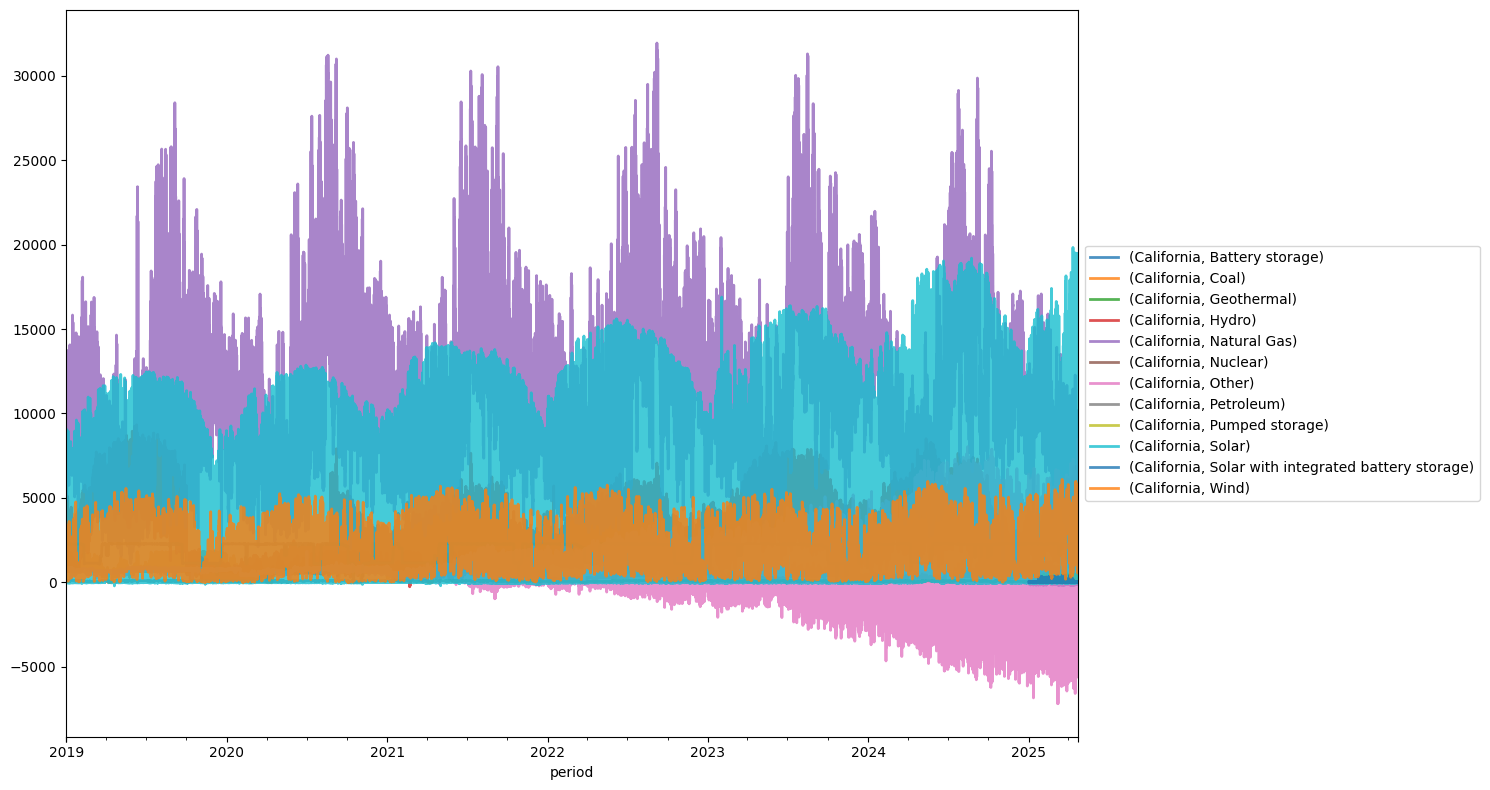

In [12]:
plot = x.unstack(level=COLUMN_CATEGORIES).plot(figsize=(15, 8), linewidth=2, alpha=0.8)
plot.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plot.figure.tight_layout()

In [13]:
series = x.copy()

### Filter one time series

To get a table with the unique datetime index of the series, and the time series values.

<div class="alert alert-warning">
Not necessary if the data already represents a time series with unique datetime values.
</div>


In [14]:
CATEGORIES = ('California', 'Hydro')

x = series.loc[CATEGORIES]
x

period
2018-12-31 16:00:00-08:00    2880
2018-12-31 17:00:00-08:00    3979
                             ... 
2025-04-22 19:00:00-07:00    4159
2025-04-22 20:00:00-07:00    5334
Name: value, Length: 55300, dtype: int64

In [15]:

from modules import utils
utils.configure_plotly_template(showlegend=True)

In [16]:
x.plot()

In [17]:
series = x.copy()

### Aggregate

**Check if you need to aggregate your data:**

- ✅ **Keep as-is** if data is already at appropriate frequency (monthly, quarterly, etc.)
- 🔄 **Aggregate first** if data is too granular for your seasonal question:
  - **Annual seasonality** → Aggregate to monthly
  - **Weekly patterns** → Aggregate to daily  
  - **Daily patterns** → Aggregate to hourly

**Rule of Thumb:**

Match your data frequency to the seasonal cycle you want to study. Most seasonal business analysis works best with **monthly data** to capture yearly patterns.

**Note**: You need at least 3-5 complete seasonal cycles for reliable decomposition results.

In [ ]:
# RULE = '1W' means the data is aggregated in weekly basis

RULE = '1W'

x = series.resample(RULE).sum()
x

period
2019-01-06 00:00:00-08:00    361153
2019-01-13 00:00:00-08:00    332769
                              ...  
2025-04-20 00:00:00-07:00    675300
2025-04-27 00:00:00-07:00    177578
Freq: W-SUN, Name: value, Length: 330, dtype: int64

In [19]:
x.plot()

In [20]:

series = x.copy()

### Filter datetime range

<div class="alert alert-warning">
Not necessary if you are interested in the whole time series. Although, it's advised to filter out outliers and incomplete data to get full periods, like full years, months, etc.
</div>

In [21]:
START, END = '2021', '2024'

In [22]:
x = series.loc[START:END]
x

period
2021-01-03 00:00:00-08:00    233140
2021-01-10 00:00:00-08:00    220242
                              ...  
2024-12-22 00:00:00-08:00    325255
2024-12-29 00:00:00-08:00    417365
Freq: W-SUN, Name: value, Length: 209, dtype: int64

In [23]:
x.plot()

In [24]:
series = x.copy()

## Individual component behaviour based on model

Components:

- Trend (T)
- Seasonality (S)
- Residual or Irregular Component (I)

Models:

- Additive model: $y_t = T_t + S_t + e_t$
- Multiplicative model: $y_t = T_t \times S_t \times e_t$

### Additive model

In [25]:
import statsmodels.api as sm

In [26]:
# Why this it use PERIOD = 52 in this case?
# Because since the data (as we can see in the previous chart) has a pattern that repeats every year, but the data is aggregated on a weekly basis and there are 52 weeks in a year, the number of periods must be 52.

PERIOD = 52

result = sm.tsa.seasonal_decompose(series, model='additive', period=PERIOD)

x = (x
 .to_frame()
 .assign(
    trend = result.trend,
    seasonal = result.seasonal,
    residual = result.resid)
 .dropna())

x

,value,trend,seasonal,residual
period,,,,
2021-07-04 00:00:00-07:00,387980,299594.519231,92901.644000,-4516.163230
2021-07-11 00:00:00-07:00,428251,301410.442308,115658.631980,11181.925712
...,...,...,...,...
2024-06-23 00:00:00-07:00,651006,581379.009615,88602.519801,-18975.529416
2024-06-30 00:00:00-07:00,617378,579598.423077,92901.644000,-55122.067077


In [27]:
x['model_result'] = x.trend + x.seasonal + x.residual
x


,value,trend,seasonal,residual,model_result
period,,,,,
2021-07-04 00:00:00-07:00,387980,299594.519231,92901.644000,-4516.163230,387980.0
2021-07-11 00:00:00-07:00,428251,301410.442308,115658.631980,11181.925712,428251.0
...,...,...,...,...,...
2024-06-23 00:00:00-07:00,651006,581379.009615,88602.519801,-18975.529416,651006.0
2024-06-30 00:00:00-07:00,617378,579598.423077,92901.644000,-55122.067077,617378.0


In [28]:
dfs = {}
dfs['additive'] = x

### Multiplicative model

In [29]:
result = sm.tsa.seasonal_decompose(series, model='multiplicative', period=PERIOD)

x = (series
 .to_frame()
 .assign(
    trend = result.trend,
    seasonal = result.seasonal,
    residual = result.resid)
 .dropna())

x

,value,trend,seasonal,residual
period,,,,
2021-07-04 00:00:00-07:00,387980,299594.519231,1.213273,1.067375
2021-07-11 00:00:00-07:00,428251,301410.442308,1.287172,1.103833
...,...,...,...,...
2024-06-23 00:00:00-07:00,651006,581379.009615,1.164781,0.961349
2024-06-30 00:00:00-07:00,617378,579598.423077,1.213273,0.877941


In [30]:
x['model_result'] = x.trend * x.seasonal * x.residual
x

,value,trend,seasonal,residual,model_result
period,,,,,
2021-07-04 00:00:00-07:00,387980,299594.519231,1.213273,1.067375,387980.0
2021-07-11 00:00:00-07:00,428251,301410.442308,1.287172,1.103833,428251.0
...,...,...,...,...,...
2024-06-23 00:00:00-07:00,651006,581379.009615,1.164781,0.961349,651006.0
2024-06-30 00:00:00-07:00,617378,579598.423077,1.213273,0.877941,617378.0


In [31]:
dfs['multiplicative'] = x

## Model comparison

### Numerical

In [32]:
df = pd.concat(dfs, axis=1).melt(ignore_index=False).reset_index()
df.columns = ["month", "model", "component", "value"]

In [33]:
df

,month,model,component,value
0,2021-07-04 00:00:00-07:00,additive,value,387980.0
1,2021-07-11 00:00:00-07:00,additive,value,428251.0
...,...,...,...,...
1568,2024-06-23 00:00:00-07:00,multiplicative,model_result,651006.0
1569,2024-06-30 00:00:00-07:00,multiplicative,model_result,617378.0


### Visual

In [34]:
import plotly.express as px

fig = px.line(
    data_frame=df,
    x='month',
    y='value',
    color='component',
    facet_col='model',
    facet_row='component',
    width=1500,
    height=1000,
    facet_col_spacing=0.1,
)

fig.update_yaxes(matches=None)

for attr in dir(fig.layout):
    if attr.startswith("yaxis"):
        axis = getattr(fig.layout, attr)
        if axis:
            axis.showticklabels = True
        
fig